In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import root_mean_squared_log_error, make_scorer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor


train_data = pd.read_csv('./data/train.csv')
transaction_data = pd.read_csv('./data/transactions.csv')


C:\Users\T-Gamer\AppData\Local\Temp\ipykernel_19540\68429043.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
print(train_data.shape)
train_data.head()

(3000888, 6)


,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [3]:
print(transaction_data.shape)
transaction_data.head()

(83488, 3)


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [4]:
# Apply left join on train_data and transaction_data
train_data = pd.merge(train_data, transaction_data, on=['date','store_nbr'], how='left')

In [5]:
# Convert date to datetime
train_data['date'] = pd.to_datetime(train_data['date'])

# Fill NaN values with 0
train_data['transactions'] = train_data['transactions'].fillna(0)

# 2017 will be used as the test set
test_data = train_data[train_data['date'].dt.year == 2017]
train_data = train_data[train_data['date'].dt.year < 2017]


# Basic prediction

## Which store sells more? Store 44, we will analyze it

In [6]:
train_data.groupby('store_nbr')['sales'].sum().sort_values(ascending=False)

store_nbr
44    5.159743e+07
45    4.484209e+07
47    4.187919e+07
3     4.176957e+07
49    3.503585e+07
46    3.465874e+07
48    2.991698e+07
51    2.754720e+07
8     2.524348e+07
50    2.373779e+07
11    2.370083e+07
7     2.217409e+07
9     2.203080e+07
6     2.094144e+07
24    1.970926e+07
2     1.799256e+07
37    1.678484e+07
39    1.651312e+07
38    1.585401e+07
4     1.578326e+07
27    1.568099e+07
28    1.496284e+07
40    1.489081e+07
31    1.472796e+07
17    1.466371e+07
34    1.452056e+07
5     1.330441e+07
43    1.310532e+07
36    1.257300e+07
41    1.204592e+07
33    1.197815e+07
1     1.170849e+07
19    1.092870e+07
18    1.068523e+07
23    9.745484e+06
15    9.595803e+06
14    9.520629e+06
16    9.503031e+06
20    9.308698e+06
25    9.283731e+06
54    8.988156e+06
13    8.948139e+06
12    8.865106e+06
53    8.504628e+06
10    8.151633e+06
29    6.915082e+06
26    6.592025e+06
35    6.391348e+06
21    6.275449e+06
30    6.075856e+06
42    5.880283e+06
32    4.821155e+06
22

In [7]:
store_data = train_data[train_data.store_nbr == 44]
store_data = store_data.reset_index(drop=True)

(array([15706., 15887., 16071., 16252., 16436., 16617., 16801., 16983.,
        17167.]),
 [Text(15706.0, 0, '2013-01'),
  Text(15887.0, 0, '2013-07'),
  Text(16071.0, 0, '2014-01'),
  Text(16252.0, 0, '2014-07'),
  Text(16436.0, 0, '2015-01'),
  Text(16617.0, 0, '2015-07'),
  Text(16801.0, 0, '2016-01'),
  Text(16983.0, 0, '2016-07'),
  Text(17167.0, 0, '2017-01')])

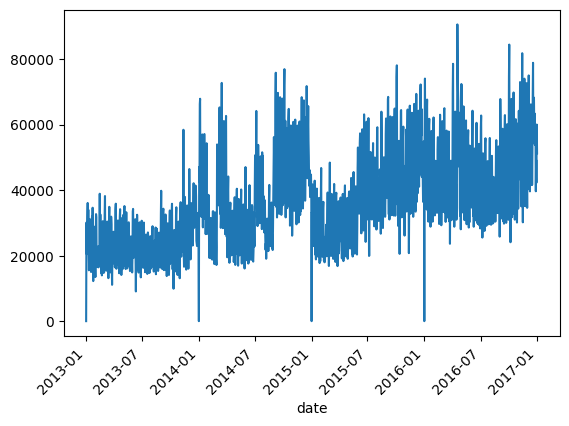

In [8]:
# See the sales data of each category by date
store_data.groupby('date')['sales'].sum().plot()
plt.xticks(rotation=45)

<Axes: xlabel='date'>

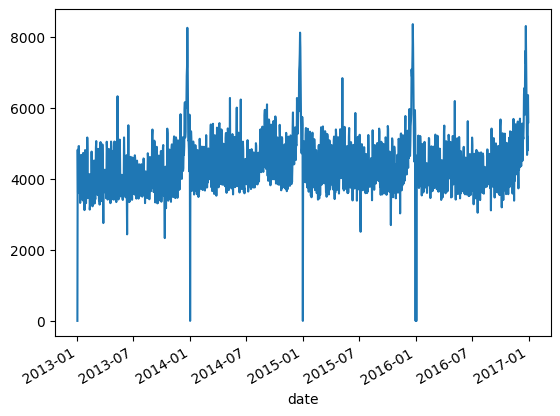

In [36]:
# See transactions data of each category by date
store_data.groupby('date')['transactions'].mean().plot()

In [10]:
x = store_data.groupby('date')['sales'].sum()
x[x == 0]

date
2013-01-01    0.0
2014-01-01    0.0
2015-01-01    0.0
2016-01-01    0.0
Name: sales, dtype: float64

In [11]:
store_data['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

### Média Mensal - Vendas e transações

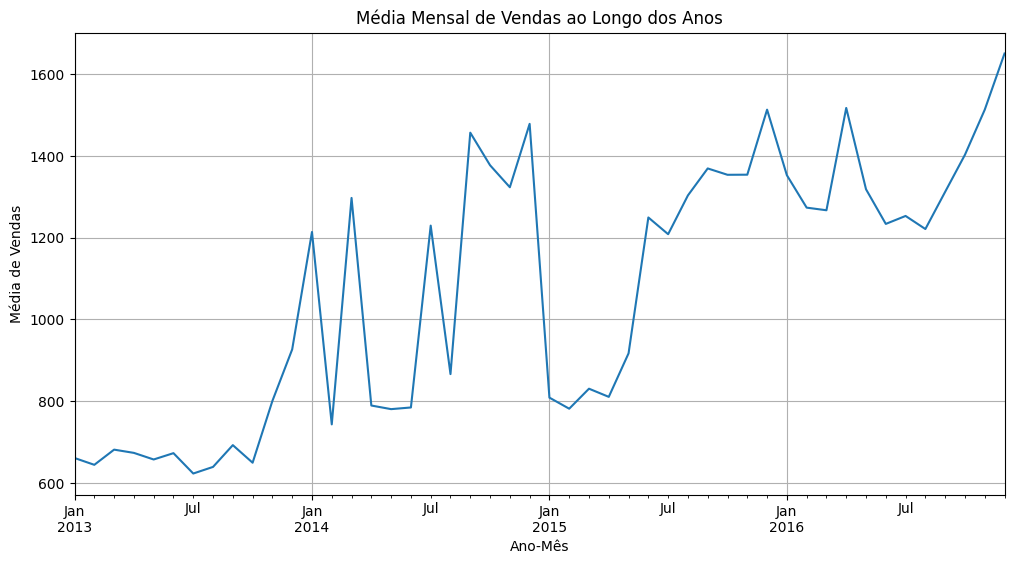

In [44]:
store_data['date'] = pd.to_datetime(store_data['date'])

store_data['year_month'] = store_data['date'].dt.to_period('M')

monthly_avg_sales = store_data.groupby('year_month')['sales'].mean()

monthly_avg_sales.plot(kind='line', figsize=(12, 6))
plt.xlabel('Ano-Mês')
plt.ylabel('Média de Vendas')
plt.title('Média Mensal de Vendas ao Longo dos Anos')

plt.grid(True)
plt.show()

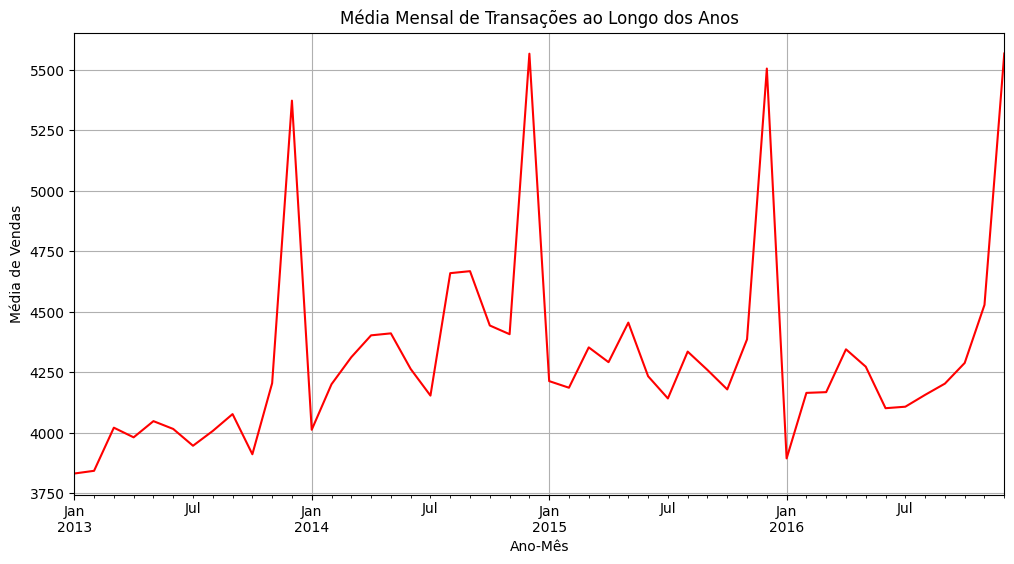

In [47]:
store_data['date'] = pd.to_datetime(store_data['date'])

store_data['year_month'] = store_data['date'].dt.to_period('M')

monthly_avg_sales = store_data.groupby('year_month')['transactions'].mean()

monthly_avg_sales.plot(kind='line', figsize=(12, 6), color='red')
plt.xlabel('Ano-Mês')
plt.ylabel('Média de Vendas')
plt.title('Média Mensal de Transações ao Longo dos Anos')


plt.grid(True)

plt.show()

### Média por Dia da semana - Vendas e transações

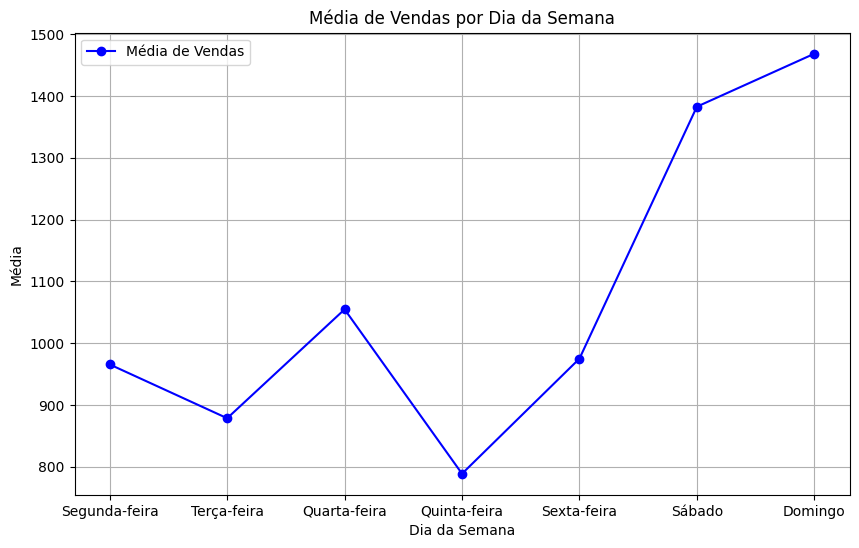

In [48]:

weekly_avg_sales = store_data.groupby('day_of_week')['sales'].mean()

days_of_week = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']

plt.figure(figsize=(10, 6))
plt.plot(days_of_week, weekly_avg_sales, marker='o', linestyle='-', color='b', label='Média de Vendas')
plt.xlabel('Dia da Semana')
plt.ylabel('Média')
plt.title('Média de Vendas por Dia da Semana')
plt.legend()
plt.grid(True)
plt.show()


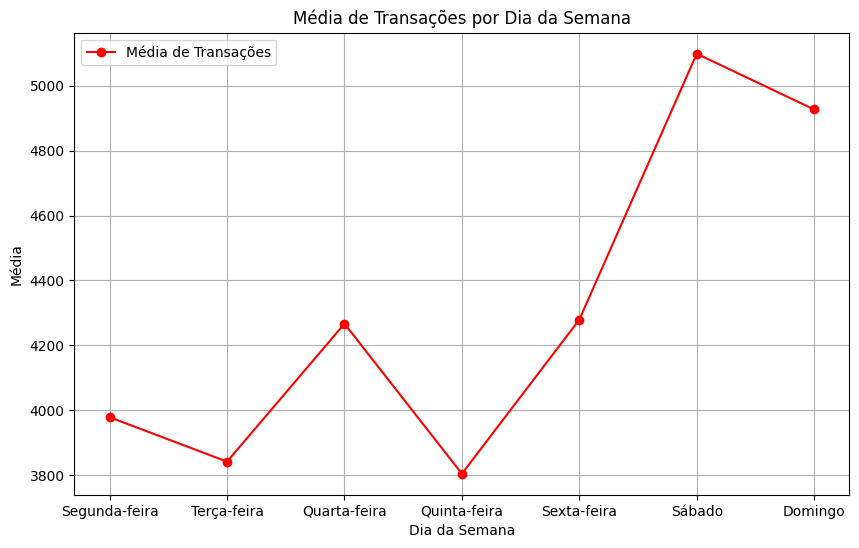

In [49]:
weekly_avg_transactions = store_data.groupby('day_of_week')['transactions'].mean()

plt.figure(figsize=(10, 6))
plt.plot(days_of_week, weekly_avg_transactions, marker='o', linestyle='-', color='r', label='Média de Transações')
plt.xlabel('Dia da Semana')
plt.ylabel('Média')
plt.title('Média de Transações por Dia da Semana')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
store_data = store_data.drop(['year_month', 'day_of_week'], axis=1)

In [52]:
# Convert date to ordinal
store_data['ordinal_date'] = store_data['date'].apply(lambda x: x.toordinal() - 734868)
store_data

,id,date,store_nbr,family,sales,onpromotion,transactions,ordinal_date
0,1254,2013-01-01,44,AUTOMOTIVE,0.00000,0,0.0,1
1,1255,2013-01-01,44,BABY CARE,0.00000,0,0.0,1
2,1256,2013-01-01,44,BEAUTY,0.00000,0,0.0,1
3,1257,2013-01-01,44,BEVERAGES,0.00000,0,0.0,1
4,1258,2013-01-01,44,BOOKS,0.00000,0,0.0,1
...,...,...,...,...,...,...,...,...
48076,2595874,2016-12-31,44,POULTRY,1268.50700,0,5598.0,1461
48077,2595875,2016-12-31,44,PREPARED FOODS,440.10602,2,5598.0,1461
48078,2595876,2016-12-31,44,PRODUCE,12032.64900,18,5598.0,1461
48079,2595877,2016-12-31,44,SCHOOL AND OFFICE SUPPLIES,1.00000,0,5598.0,1461


### See correlation - Pearson and Spearman

<Axes: >

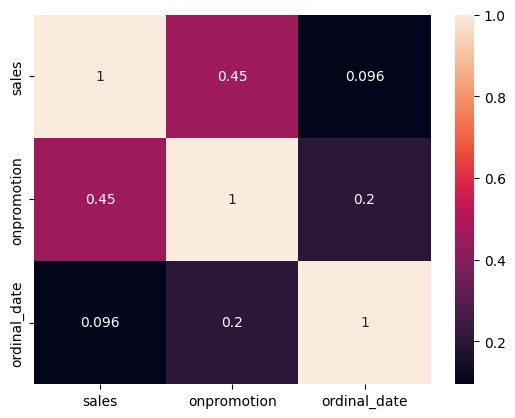

In [53]:
sns.heatmap(store_data[['sales', 'onpromotion','ordinal_date']].corr('pearson'), annot=True)

<Axes: >

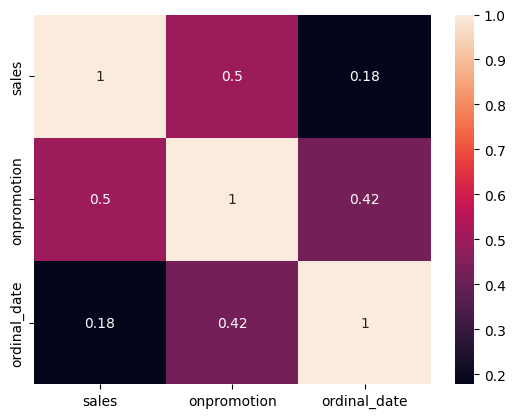

In [54]:
sns.heatmap(store_data[['sales', 'onpromotion','ordinal_date']].corr('spearman'), annot=True)

<Axes: >

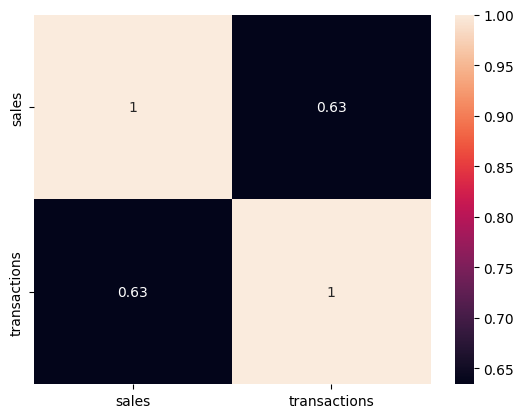

In [55]:
# See correlation between sum of sales and sum of transactions
sns.heatmap(store_data.groupby('date')[['sales', 'transactions']].sum().corr('pearson'), annot=True)

<Axes: >

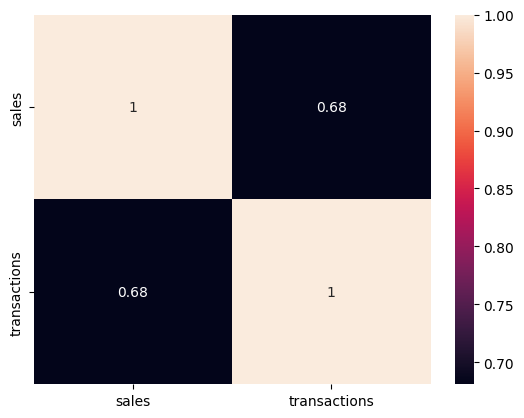

In [56]:
# See correlation between sum of sales and sum of transactions
sns.heatmap(store_data.groupby('date')[['sales', 'transactions']].sum().corr('spearman'), annot=True)

In [57]:
one_hot = OneHotEncoder(sparse_output=False)

family_one_hot = one_hot.fit_transform(store_data['family'].values.reshape(-1, 1))

# Concatenate the one hot encoded data with the original data
family_one_hot_df = pd.DataFrame(family_one_hot, columns=one_hot.get_feature_names_out())
store_data = pd.concat([store_data, family_one_hot_df], axis=1)

In [59]:
# Drop columns that are not needed
store_data = store_data.drop(columns=['id','family','date','store_nbr'])

## Scaling the features

In [41]:
scaler = StandardScaler()

Y_store_data = store_data['sales']
X_store_data = store_data.drop(columns=['sales'])

X_scaled_store_data = scaler.fit_transform(X_store_data)

X_scaled_store_data = pd.DataFrame(X_scaled_store_data, columns=X_store_data.columns)


In [42]:
X_scaled_store_data

,onpromotion,ordinal_date,x0_AUTOMOTIVE,x0_BABY CARE,x0_BEAUTY,x0_BEVERAGES,x0_BOOKS,x0_BREAD/BAKERY,x0_CELEBRATION,x0_CLEANING,...,x0_MAGAZINES,x0_MEATS,x0_PERSONAL CARE,x0_PET SUPPLIES,x0_PLAYERS AND ELECTRONICS,x0_POULTRY,x0_PREPARED FOODS,x0_PRODUCE,x0_SCHOOL AND OFFICE SUPPLIES,x0_SEAFOOD
0,-0.195035,-1.729987,5.656854,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,...,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777
1,-0.195035,-1.729987,-0.176777,5.656854,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,...,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777
2,-0.195035,-1.729987,-0.176777,-0.176777,5.656854,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,...,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777
3,-0.195035,-1.729987,-0.176777,-0.176777,-0.176777,5.656854,-0.176777,-0.176777,-0.176777,-0.176777,...,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777
4,-0.195035,-1.729987,-0.176777,-0.176777,-0.176777,-0.176777,5.656854,-0.176777,-0.176777,-0.176777,...,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48076,-0.195035,1.732276,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,...,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,5.656854,-0.176777,-0.176777,-0.176777,-0.176777
48077,-0.050782,1.732276,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,...,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,5.656854,-0.176777,-0.176777,-0.176777
48078,1.103246,1.732276,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,...,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,5.656854,-0.176777,-0.176777
48079,-0.195035,1.732276,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,...,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,-0.176777,5.656854,-0.176777


## Testing models

In [43]:
models_to_test = []
rmsle_error = []

model_dict = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'K Neighbors Regressor': KNeighborsRegressor(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'Adaboost Regressor': AdaBoostRegressor()
}

# Creating scorer for the cross validation
rmsle_scorer = make_scorer(root_mean_squared_log_error, greater_is_better=False)

# Creating a Function to append the cross validation scores of the algorithms
def input_scores(name, model, x, y):
    tscv = TimeSeriesSplit(n_splits=5)
    models_to_test.append(name)
    scores = cross_val_score(model, x, y, cv=tscv, scoring=rmsle_scorer)
    
    # get predictions
    
    rmsle_error.append(scores.mean())

# Loop through the models and append the scores
for name, model in model_dict.items():
    input_scores(name, model, X_scaled_store_data, Y_store_data)

c:\Users\T-Gamer\anaconda3\envs\ACELab\Lib\site-packages\sklearn\model_selection\_validation.py:1011: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Users\T-Gamer\anaconda3\envs\ACELab\Lib\site-packages\sklearn\metrics\_scorer.py", line 137, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Users\T-Gamer\anaconda3\envs\ACELab\Lib\site-packages\sklearn\metrics\_scorer.py", line 350, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\T-Gamer\anaconda3\envs\ACELab\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\T-Gamer\anaconda3\envs\ACELab\Lib\site-packages\sklearn\metrics\_regression.py", line 759, in root_mean_

In [44]:
rmsle_error

[nan,
 nan,
 nan,
 -1.2693689177761986,
 -1.7998289090788706,
 -1.2954741291267953,
 -2.425479379927696,
 -3.779917405827125]

In [45]:


test_data = test_data[test_data.store_nbr == 44]
test_data = test_data.reset_index(drop=True)

test_data['ordinal_date'] = test_data['date'].apply(lambda x: x.toordinal() - 734868)
one_hot = OneHotEncoder(sparse_output=False)

family_one_hot = one_hot.fit_transform(test_data['family'].values.reshape(-1, 1))

# Concatenate the one hot encoded data with the original data
family_one_hot_df = pd.DataFrame(family_one_hot, columns=one_hot.get_feature_names_out())
test_data = pd.concat([test_data, family_one_hot_df], axis=1)

test_data = test_data.drop(columns=['id','family','date','store_nbr'])

scaler = StandardScaler()

test_data = test_data.drop(columns=['sales'])

X_scaled_test_data = scaler.fit_transform(test_data)

X_scaled_test_data = pd.DataFrame(X_scaled_test_data, columns=test_data.columns)

linear_model = LinearRegression()
linear_model.fit(X_scaled_test_data, Y_store_data)

pred = linear_model.predict(test_data)